In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
### EDA video_games_sales.csv ###
df_video_games = pd.read_csv('Data/video_games_sales.csv')
print("Primeras filas del dataset")
print(df_video_games.head(10))



Primeras filas del dataset
   Rank                       Name Platform    Year         Genre Publisher  \
0     1                 Wii Sports      Wii  2006.0        Sports  Nintendo   
1     2          Super Mario Bros.      NES  1985.0      Platform  Nintendo   
2     3             Mario Kart Wii      Wii  2008.0        Racing  Nintendo   
3     4          Wii Sports Resort      Wii  2009.0        Sports  Nintendo   
4     5   Pokemon Red/Pokemon Blue       GB  1996.0  Role-Playing  Nintendo   
5     6                     Tetris       GB  1989.0        Puzzle  Nintendo   
6     7      New Super Mario Bros.       DS  2006.0      Platform  Nintendo   
7     8                   Wii Play      Wii  2006.0          Misc  Nintendo   
8     9  New Super Mario Bros. Wii      Wii  2009.0      Platform  Nintendo   
9    10                  Duck Hunt      NES  1984.0       Shooter  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  
0     41.49     29.02      3.77         8.

In [3]:
print("\nDimensiones del dataset:")
print(f"Filas: {df_video_games.shape[0]}, Columnas: {df_video_games.shape[1]}")


Dimensiones del dataset:
Filas: 16598, Columnas: 11


In [4]:
print("\nTipos de datos:")
print(df_video_games.dtypes)


Tipos de datos:
Rank              int64
Name             object
Platform         object
Year            float64
Genre            object
Publisher        object
NA_Sales        float64
EU_Sales        float64
JP_Sales        float64
Other_Sales     float64
Global_Sales    float64
dtype: object


In [5]:
print("\nValores nulos por columna:")
print(df_video_games.isnull().sum())


Valores nulos por columna:
Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64


In [6]:
print("\nEstadísticas de ventas por región y globales:")
print(df_video_games[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']].describe())


Estadísticas de ventas por región y globales:
           NA_Sales      EU_Sales      JP_Sales   Other_Sales  Global_Sales
count  16598.000000  16598.000000  16598.000000  16598.000000  16598.000000
mean       0.264667      0.146652      0.077782      0.048063      0.537441
std        0.816683      0.505351      0.309291      0.188588      1.555028
min        0.000000      0.000000      0.000000      0.000000      0.010000
25%        0.000000      0.000000      0.000000      0.000000      0.060000
50%        0.080000      0.020000      0.000000      0.010000      0.170000
75%        0.240000      0.110000      0.040000      0.040000      0.470000
max       41.490000     29.020000     10.220000     10.570000     82.740000


In [7]:
## limpieza de video_games_sales.csv --> video_game_sales_limpio ##
df_video_games1 = df_video_games.drop_duplicates()
df_video_games2 = df_video_games1.dropna(subset=['Year', 'Publisher'])
df_video_games_limpio = df_video_games2[df_video_games2['Global_Sales'] > 0]
df_video_games_limpio['Year'] = df_video_games_limpio['Year'].astype(int)

In [8]:
print(f"Filas: {df_video_games_limpio.shape[0]}, Columnas: {df_video_games_limpio.shape[1]}")
print(df_video_games_limpio.dtypes)

Filas: 16291, Columnas: 11
Rank              int64
Name             object
Platform         object
Year              int64
Genre            object
Publisher        object
NA_Sales        float64
EU_Sales        float64
JP_Sales        float64
Other_Sales     float64
Global_Sales    float64
dtype: object


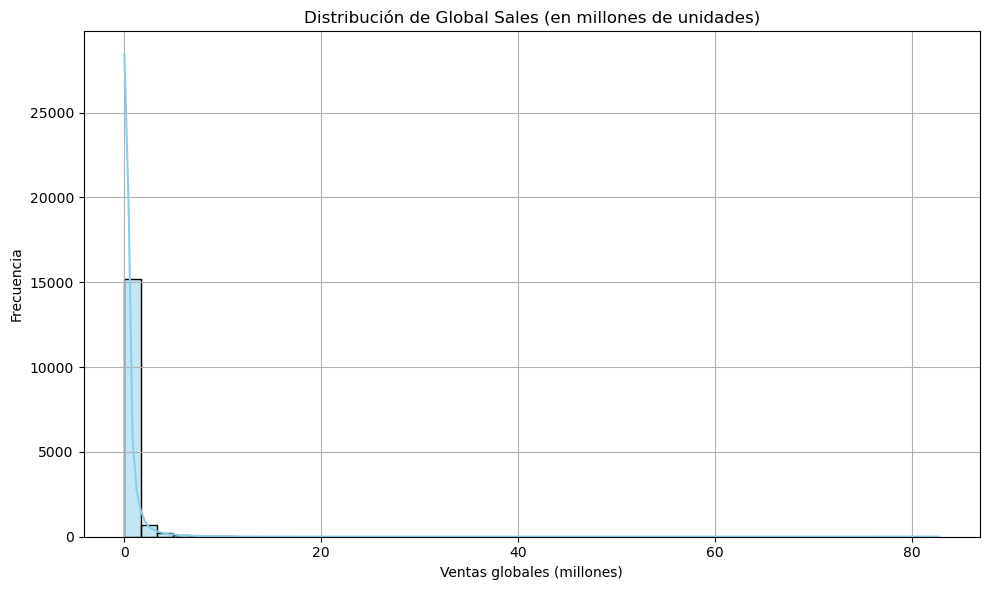

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(df_video_games_limpio['Global_Sales'], bins=50, kde=True, color='skyblue')
plt.title('Distribución de Global Sales (en millones de unidades)')
plt.xlabel('Ventas globales (millones)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.tight_layout()
plt.show()

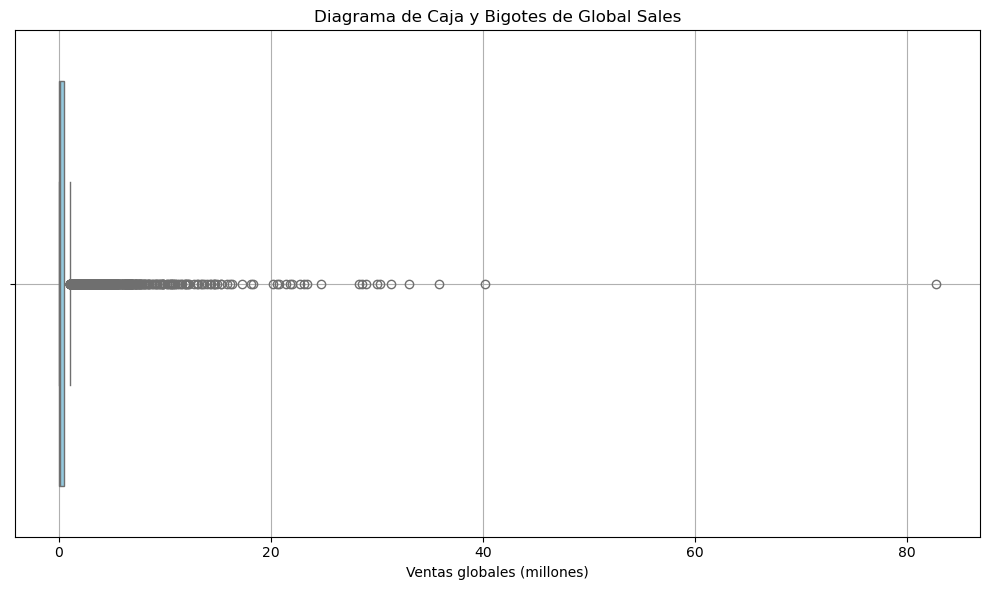

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_video_games_limpio['Global_Sales'], color='skyblue')
plt.title('Diagrama de Caja y Bigotes de Global Sales')
plt.xlabel('Ventas globales (millones)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
df_video_games_limpio.to_csv('Data/video_games_sales_limpio.csv', index=False)

In [18]:
#### categorización de ventas ####

def clasificar_ventas(ventas):
    if ventas <= 0.5:
        return 'Normal'
    elif 0.5 < ventas <= 2:
        return 'Alta'
    elif 2 < ventas <= 10:
        return 'Muy ALta'
    else:
        return 'Gran Éxito'
 ## incluir nueva columna ###   
df_video_games_limpio['Ventas_Clase'] = df_video_games_limpio['Global_Sales'].apply(clasificar_ventas)
df_video_games_limpio.to_csv('Data/video_games_sales_limpio.csv', index=False)

In [19]:
print(df_video_games_limpio['Ventas_Clase'].value_counts())

Ventas_Clase
Normal        12401
Alta           3054
Muy ALta        774
Gran Éxito       62
Name: count, dtype: int64


In [20]:
## Union de video_games_ sales_ limpio y all_video_games(cleaned).csv ##
df_all_games = pd.read_csv('Data/all_video_games(cleaned).csv')

In [25]:
df_video_games_limpio['Title'] = df_video_games_limpio['Name'].str.strip().str.lower()
df_all_games['Title'] = df_all_games['Title'].str.strip().str.lower()
df_all_games_limpio = df_all_games[['Title', 'Product Rating', 'User Score', 'User Ratings Count', 'Platforms Info']]

In [26]:
df_video_games_unido = pd.merge(df_video_games_limpio, df_all_games_limpio, on='Title', how='left')

In [27]:
# Verificar forma final y valores nulos
print("Forma del dataframe combinado:", df_video_games_unido.shape)
print("\nValores nulos por columna:")
print(df_video_games_unido.isnull().sum())

Forma del dataframe combinado: (16291, 17)

Valores nulos por columna:
Rank                     0
Name                     0
Platform                 0
Year                     0
Genre                    0
Publisher                0
NA_Sales                 0
EU_Sales                 0
JP_Sales                 0
Other_Sales              0
Global_Sales             0
Ventas_Clase             0
Title                    0
Product Rating        8655
User Score            9629
User Ratings Count    9920
Platforms Info        8575
dtype: int64


In [28]:
consolas_distintas = df_video_games_unido['Platform'].unique()
print(consolas_distintas)

['Wii' 'NES' 'GB' 'DS' 'X360' 'PS3' 'PS2' 'SNES' 'GBA' '3DS' 'PS4' 'N64'
 'PS' 'XB' 'PC' '2600' 'PSP' 'XOne' 'GC' 'WiiU' 'GEN' 'DC' 'PSV' 'SAT'
 'SCD' 'WS' 'NG' 'TG16' '3DO' 'GG' 'PCFX']
